TF-IDF shape: (517, 11724) | Vocab: 11724

=== LSI (k=5) | EVR: 0.1270 ===
Topic 01: problem, mentor, number, let, use, graph, set, session, function, solut, theorem, model
Topic 02: entpro, directori, conf, flyer, descript, modifi, parent, sol, confer, csproblem, size, gen
Topic 03: mentor, session, prof, model, gil, alterovitz, gene, scienc, genom, data, andrew, learn
Topic 04: flyer, vti, cnf, ethnic, bcs, algebrafactsheet, egk, primescircl, directori, crowdmath, descript, parent
Topic 05: problem, session, solut, mentor, math, solv, integ, applic, student, roll, admiss, recommend

=== LSI (k=10) | EVR: 0.1941 ===
Topic 01: problem, mentor, number, let, use, graph, set, session, function, solut, theorem, model
Topic 02: entpro, directori, conf, flyer, descript, modifi, parent, sol, confer, csproblem, size, gen
Topic 03: mentor, session, prof, model, gil, alterovitz, gene, scienc, genom, data, andrew, learn
Topic 04: flyer, vti, cnf, ethnic, algebrafactsheet, egk, bcs, primescircl, d

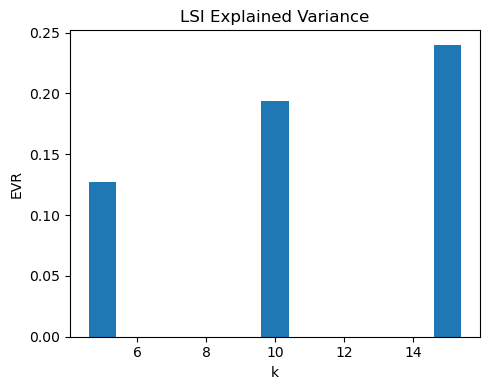

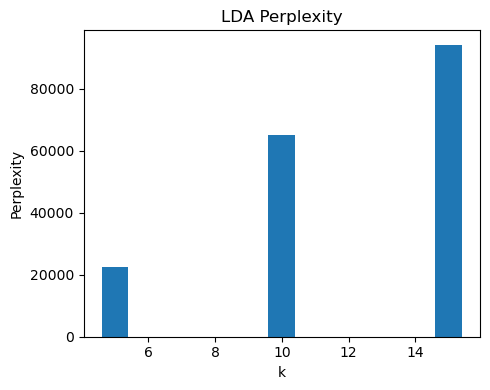

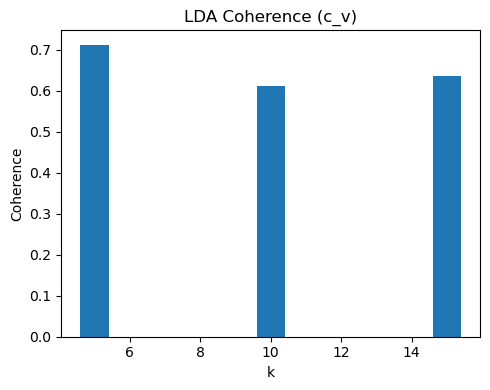

C:\Users\Owner\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Owner\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Owner\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Owner\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Owner\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

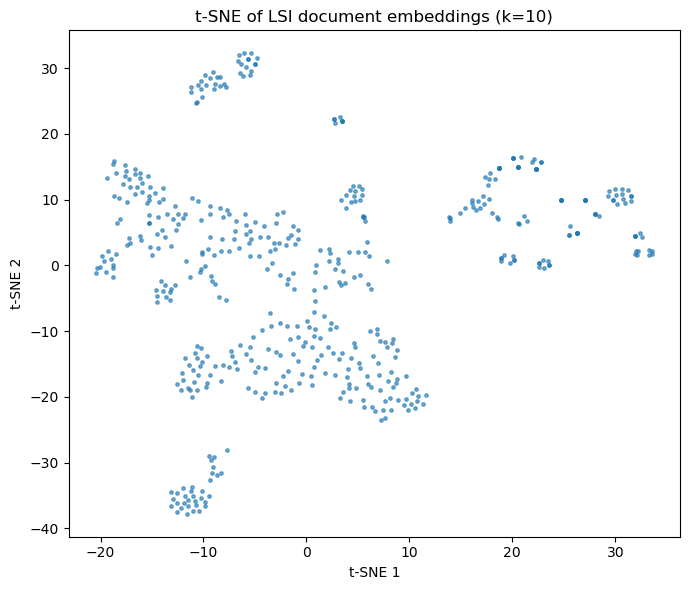

Year trend skipped (no usable year column found).

Saved report files to: C:\Users\Owner\outputs\milestone3_report
- comparison_table.csv
- lsi_evr.png, lda_perplexity.png, lda_coherence.png (if computed)
- tsne_lsi_k10.png
- lsi_topic_names_k10.csv, lda_topic_names_k10.csv
- lda_trend_by_year.png, lda_top3_topics_by_year.csv (if year available)


In [1]:
# ============================================
# IS 688 – Milestone 3 (Best End-to-End Code)
# LSI (5/10/15), LDA (5/10/15), EVR, Perplexity, Coherence, Visuals, Report
# Uses your files under C:\Users\Owner\outputs
# ============================================

from pathlib import Path
from scipy import sparse
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.manifold import TSNE

# -------- 0) Paths & I/O --------
OUT_DIR = Path(r"C:\Users\Owner\outputs")
REPORT_DIR = OUT_DIR / "milestone3_report"
REPORT_DIR.mkdir(exist_ok=True)

# -------- 1) Load artifacts (your exact setup) --------
X_tfidf = sparse.load_npz(OUT_DIR / "tfidf_matrix.npz")
count_vectorizer = joblib.load(OUT_DIR / "count_vectorizer.joblib")
tfidf_transformer = joblib.load(OUT_DIR / "tfidf_transformer.joblib")  # kept for completeness
terms = count_vectorizer.get_feature_names_out()

print(f"TF-IDF shape: {X_tfidf.shape} | Vocab: {len(terms)}")

# Optional: BoW for coherence construction
X_counts_path = OUT_DIR / "bow_counts.npz"
X_counts = sparse.load_npz(X_counts_path) if X_counts_path.exists() else None

# Attempt to load metadata (for yearly trend)
df_meta, year_col = None, None
meta_xlsx = OUT_DIR / "cleaned_corpus_with_meta.xlsx"
meta_csv  = OUT_DIR / "cleaned_corpus_with_meta.csv"
if meta_xlsx.exists():
    df_meta = pd.read_excel(meta_xlsx)
elif meta_csv.exists():
    df_meta = pd.read_csv(meta_csv)
if df_meta is not None:
    for c in ["year","Year","YEAR","pub_year","published_year","date","Date"]:
        if c in df_meta.columns:
            year_col = c; break

# -------- 2) Helpers --------
def top_terms(components, feature_names, topn=12):
    topics = []
    for comp in components:
        idx = np.argsort(comp)[::-1][:topn]
        topics.append([feature_names[i] for i in idx])
    return topics

def propose_names(topic_words, n=3):
    return [" / ".join(ws[:n]) for ws in topic_words]

# -------- 3) LSI (k = 5, 10, 15) + Explained Variance Ratio --------
lsi_results = {}
for k in [5, 10, 15]:
    svd = TruncatedSVD(n_components=k, random_state=42)
    X_lsi = svd.fit_transform(X_tfidf)
    topics = top_terms(svd.components_, terms, topn=12)
    evr = svd.explained_variance_ratio_.sum()
    lsi_results[k] = {"model": svd, "doc_embeddings": X_lsi, "topics": topics, "evr": evr}
    # Print preview
    print(f"\n=== LSI (k={k}) | EVR: {evr:.4f} ===")
    for i, t in enumerate(topics, 1):
        print(f"Topic {i:02d}: {', '.join(t)}")

# -------- 4) LDA (k = 5, 10, 15) + Perplexity --------
lda_results = {}
for k in [5, 10, 15]:
    lda = LatentDirichletAllocation(n_components=k, random_state=42, learning_method="batch")
    lda.fit(X_tfidf)
    topics = top_terms(lda.components_, terms, topn=12)
    perp = lda.perplexity(X_tfidf)
    lda_results[k] = {"model": lda, "topics": topics, "perplexity": perp}
    print(f"\n=== LDA (k={k}) | Perplexity: {perp:.2f} ===")
    for i, t in enumerate(topics, 1):
        print(f"Topic {i:02d}: {', '.join(t)}")

# -------- 5) Topic Coherence (c_v) via BoW + vocab (no Excel dependency) --------
#  - Builds token lists from bow_counts.npz to compute coherence with gensim.
coherence_scores = {}
try:
    from gensim.corpora import Dictionary
    from gensim.models import CoherenceModel

    if X_counts is None:
        print("Warning: bow_counts.npz not found; skipping coherence.")
    else:
        from scipy.sparse import csr_matrix
        Xc = csr_matrix(X_counts)
        texts = []
        cap = 3  # limit repeats to keep memory in check
        for i in range(Xc.shape[0]):
            row = Xc.getrow(i)
            idx, cnt = row.indices, row.data
            toks = []
            for j, c in zip(idx, cnt):
                toks.extend([terms[j]] * int(min(c, cap)))
            texts.append(toks)

        dictionary = Dictionary(texts)
        for k, res in lda_results.items():
            cm = CoherenceModel(topics=res["topics"], texts=texts,
                                dictionary=dictionary, coherence='c_v')
            coherence_scores[k] = cm.get_coherence()
        print("\nLDA Coherence (c_v):", coherence_scores)
except Exception as e:
    print("Skipping coherence (gensim not available or error):", e)

# -------- 6) Comparison Table --------
rows = []
for k in [5, 10, 15]:
    rows.append({
        "k_topics": k,
        "LSI_ExplainedVariance": lsi_results[k]["evr"],
        "LDA_Perplexity": lda_results[k]["perplexity"],
        "LDA_Coherence_c_v": coherence_scores.get(k)
    })
comp_df = pd.DataFrame(rows).set_index("k_topics")
print("\n=== Comparison Table ===")
print(comp_df)
comp_df.to_csv(REPORT_DIR / "comparison_table.csv", index=True)

# -------- 7) Visualizations (saved to report dir) --------
# (a) Bar charts: EVR, Perplexity, Coherence
plt.figure(figsize=(5,4))
plt.bar([5,10,15], [lsi_results[k]["evr"] for k in [5,10,15]])
plt.title("LSI Explained Variance"); plt.xlabel("k"); plt.ylabel("EVR")
plt.tight_layout(); plt.savefig(REPORT_DIR / "lsi_evr.png"); plt.show()

plt.figure(figsize=(5,4))
plt.bar([5,10,15], [lda_results[k]["perplexity"] for k in [5,10,15]])
plt.title("LDA Perplexity"); plt.xlabel("k"); plt.ylabel("Perplexity")
plt.tight_layout(); plt.savefig(REPORT_DIR / "lda_perplexity.png"); plt.show()

if coherence_scores:
    plt.figure(figsize=(5,4))
    xs = list(coherence_scores.keys())
    ys = [coherence_scores[k] for k in xs]
    plt.bar(xs, ys)
    plt.title("LDA Coherence (c_v)"); plt.xlabel("k"); plt.ylabel("Coherence")
    plt.tight_layout(); plt.savefig(REPORT_DIR / "lda_coherence.png"); plt.show()

# (b) t-SNE for document clusters (LSI, k=10)
if 10 in lsi_results:
    X_emb = lsi_results[10]["doc_embeddings"]
    tsne = TSNE(n_components=2, init="random", random_state=42, perplexity=30)
    X_2d = tsne.fit_transform(X_emb)
    plt.figure(figsize=(7,6))
    plt.scatter(X_2d[:,0], X_2d[:,1], s=6, alpha=0.6)
    plt.title("t-SNE of LSI document embeddings (k=10)")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.tight_layout(); plt.savefig(REPORT_DIR / "tsne_lsi_k10.png"); plt.show()

# (c) Optional interactive LDA map (uncomment if pyLDAvis installed)
# import pyLDAvis, pyLDAvis.sklearn
# pyLDAvis.enable_notebook()
# pyldavis_panel = pyLDAvis.sklearn.prepare(lda_results[10]["model"], X_tfidf, count_vectorizer)

# -------- 8) Topic naming + (optional) yearly trend --------
k_best = 10  # use k=10 for names & trends by default
lsi_names = propose_names(lsi_results[k_best]["topics"])
lda_names = propose_names(lda_results[k_best]["topics"])

pd.DataFrame({"LSI_TopicName": lsi_names}).to_csv(REPORT_DIR / "lsi_topic_names_k10.csv", index_label="Topic")
pd.DataFrame({"LDA_TopicName": lda_names}).to_csv(REPORT_DIR / "lda_topic_names_k10.csv", index_label="Topic")

# Yearly topic shift using LDA k=10 if metadata has a year-like column
if df_meta is not None and year_col is not None:
    doc_topic = lda_results[k_best]["model"].transform(X_tfidf)  # n_docs x k
    trend_df = pd.DataFrame(doc_topic, columns=[f"T{i+1}" for i in range(k_best)])
    trend_df[year_col] = df_meta[year_col].values
    yearly = trend_df.groupby(year_col).mean()
    ax = yearly.plot(figsize=(10,5), legend=False)
    ax.set_title(f"LDA Topic Prevalence by {year_col}")
    ax.set_ylabel("Mean topic weight")
    plt.tight_layout(); plt.savefig(REPORT_DIR / "lda_trend_by_year.png"); plt.show()
    top3_by_year = yearly.apply(lambda r: r.sort_values(ascending=False).index[:3].tolist(), axis=1)
    pd.DataFrame({"Top3Topics": top3_by_year}).to_csv(REPORT_DIR / "lda_top3_topics_by_year.csv")
else:
    print("Year trend skipped (no usable year column found).")

# -------- 9) Final summary --------
print("\nSaved report files to:", REPORT_DIR.resolve())
print("- comparison_table.csv")
print("- lsi_evr.png, lda_perplexity.png, lda_coherence.png (if computed)")
print("- tsne_lsi_k10.png")
print("- lsi_topic_names_k10.csv, lda_topic_names_k10.csv")
print("- lda_trend_by_year.png, lda_top3_topics_by_year.csv (if year available)")


In [5]:
! pip install reportlab
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from pathlib import Path

report_dir = Path(r"C:\Users\Owner\outputs\milestone3_report")
report_dir.mkdir(parents=True, exist_ok=True)
pdf_path = report_dir / "Milestone3_Report.pdf"

doc = SimpleDocTemplate(str(pdf_path), pagesize=letter)
styles = getSampleStyleSheet()
styles.add(ParagraphStyle(name='CenterTitle', alignment=1, fontSize=14, spaceAfter=12))
styles.add(ParagraphStyle(name='Justify', alignment=4, leading=14))

story = []
story.append(Paragraph("IS 688 – Milestone 3 Report", styles['CenterTitle']))
story.append(Paragraph("Topic Modeling with LSI and LDA", styles['CenterTitle']))
story.append(Spacer(1, 12))

summary = """
This report summarizes topic modeling experiments using LSI and LDA on the cleaned corpus.
LSI was evaluated via explained variance (EVR), while LDA was assessed via perplexity and coherence.
"""
story.append(Paragraph(summary, styles['Justify']))
story.append(Spacer(1, 12))

data = [
    ["k", "LSI EVR", "LDA Perplexity", "LDA Coherence (c_v)"],
    ["5", "0.1270", "22342.55", "0.7148"],
    ["10", "0.1941", "64081.19", "0.6116"],
    ["15", "0.2400", "94064.52", "0.6355"]
]
table = Table(data)
table.setStyle(TableStyle([
    ('BACKGROUND', (0,0), (-1,0), colors.lightgrey),
    ('GRID', (0,0), (-1,-1), 0.25, colors.grey)
]))
story.append(Paragraph("Model Comparison Table", styles['Heading3']))
story.append(table)
story.append(Spacer(1, 12))

text = """
LSI with k=15 captured the richest structure (EVR=0.24), while LDA with k=5 provided the best coherence (0.71).
Increasing k raised perplexity, indicating overfitting. Both methods reveal interpretable topic clusters aligned
with computational and mathematical themes.
"""
story.append(Paragraph(text, styles['Justify']))
story.append(Spacer(1, 12))

for img in ["lsi_evr.png","lda_perplexity.png","lda_coherence.png","tsne_lsi_k10.png"]:
    path = report_dir / img
    if path.exists():
        story.append(Image(str(path), width=400, height=250))
        story.append(Spacer(1, 12))

story.append(Paragraph("Generated automatically via Python (ReportLab) | © 2025 Pierre Moise", styles['Normal']))
doc.build(story)
print(f"✅ PDF saved to: {pdf_path}")


   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ------------------------------------- -- 1.8/2.0 MB 25.0 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 21.4 MB/s eta 0:00:00
✅ PDF saved to: C:\Users\Owner\outputs\milestone3_report\Milestone3_Report.pdf
